## Project: Build a Traffic Sign Recognition Classifier

Author : Mouad HADJI, November 11th, 2017

In this project, I will explain how to 

---
## 1. Import packages

In this section, we import the packages we will use throughout the project. If there is the need for other packages, we will load them later.

In [1]:
import os
import sys
import glob
import pickle
import cv2
import random
from scipy import ndimage
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## 2. Load The Data

We first load the 3 datasets (train, validation, test) that will allow us to train, measure the performance and evaluate our classifier

In [2]:
project_path = os.path.join(os.environ['HOME'], "sdcnd/sdcnd_traffic_sign_classifier")
data_path = os.path.join(os.environ['HOME'], "sdcnd/sdcnd_traffic_sign_classifier/traffic-signs-data")
model_path = os.path.join(os.environ['HOME'], "sdcnd/sdcnd_traffic_sign_classifier/models")

In [3]:
training_file = os.path.join(data_path, "train.p")
validation_file= os.path.join(data_path, "valid.p")
testing_file = os.path.join(data_path, "test.p")

In [4]:
with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

In [28]:
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

Here, we shuffle the training data.

In [29]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

## 3. Data Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image.

In [30]:
# Number of training examples
n_train = len(X_train)

# Number of validation examples
n_validation = len(X_valid)

# Number of testing examples.
n_test = len(X_test)

# Shape of an traffic sign image
image_shape = train['features'][0].shape

# Number of unique classes/labels there are in the dataset
n_classes = len(set(train['labels']))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


`sign_names` contains the names of the names. Let's load it and check out the label names

In [31]:
sign_names = pd.read_csv(os.path.join(project_path, "signnames.csv"))
sign_names.head()

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)


### Visualize the dataset :

#### Plotting a sample traffic sign

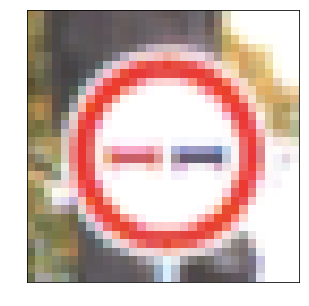

In [32]:
plt.figure(figsize=(5,5))
plt.grid(False)
plt.tick_params(axis='x', colors=(0,0,0,0))
plt.tick_params(axis='y', colors=(0,0,0,0))
plt.imshow(X_train[453])

Let's verify that the description of the labels is correct :

In [33]:
sign_names.loc[sign_names.ClassId == y_train[453]]['SignName']

9    No passing
Name: SignName, dtype: object

#### Plotting the distribution of the classes

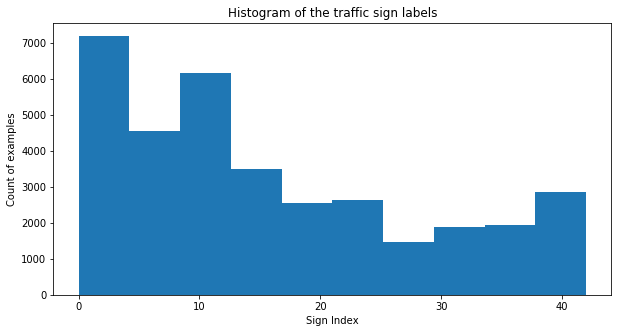

In [34]:
plt.figure(figsize=(10,5))
plt.xlabel("Sign Index")
plt.ylabel("Count of examples")
plt.hist(y_train)
plt.title("Histogram of the traffic sign labels")
plt.show()

We can note that the dataset is not balanced at all. This is not optimal but hopefully we can achieve great performance with this imbalanced dataset.

----

## 4. Design and Test a Model Architecture

Let us now design and implement a deep learning model that learns to recognize traffic signs.

### 4.i. Pre-process the images

In this step, we want to pre-process the image data. They are several transformation we can implement : normalization, grayscale, etc. We will implement several of them below.

In [35]:
def normalize(img):
    return (img - np.mean(img))/np.std(img)

In [36]:
def gray_scale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [37]:
def pre_process_img(img):
    img_1 = normalize(img)
    img_2 = gray_scale(img)
    return img_2

In [38]:
X_train = np.array([pre_process_img(img) for img in list(X_train)])
X_valid = np.array([pre_process_img(img) for img in list(X_valid)])
X_test = np.array([pre_process_img(img) for img in list(X_test)])

In [39]:
X_train = X_train[:,:,:,np.newaxis]
X_valid = X_valid[:,:,:,np.newaxis]
X_test = X_test[:,:,:,np.newaxis]

### 4.ii. Model Architecture

In this example, we will implement the [LeNet-5](http://yann.lecun.com/exdb/lenet/) neural network architecture. We will describe below all the details of the model architecture.

#### Inputs

The number of color channels here is `3`. If we decide to grayscale, the number of channels will be reduced to `1`. The LeNet architecture accepts a 32x32xC image as input, where C is the number of color channels.

#### Outputs

The number of classes to label is 43. Hence the length of Logits layer will be 43.

#### Architecture :  5 Layers (CONV-POOL, CONV-POOL, FC, FC, FC)

**Layer 1: Convolutional.** The output shape should be 28x28x6.
**Activation.** RELU.
**Pooling.** The output shape should be 14x14x6.

**Layer 2: Convolutional.** The output shape should be 10x10x16.
**Activation.** RELU.
**Pooling.** The output shape should be 5x5x16.
**Flatten.** Flatten the output shape of the final pooling layer such that it's 1D instead of 3D.

**Layer 3: Fully Connected.** This should have 120 outputs.
**Activation.** RELU.

**Layer 4: Fully Connected.** This should have 84 outputs.
**Activation.** RELU.

**Layer 5: Fully Connected (Logits).** This should have 43 outputs.

In [40]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten

Let's define here the basic **CONV** and **POOL** layers that we will use multiple times : 

In [41]:
def conv2d(x, weights, biases, strides=1, padding='VALID'):
    conv = tf.nn.conv2d(x, weights, strides=[1, strides, strides, 1], padding=padding)
    conv = tf.add(conv, biases)
    return conv

def maxpool2d(x, k=2, padding='VALID'):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding=padding)

In [42]:
def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    ########################## LAYER 1
    
    w_1 = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    b_1 = tf.Variable(tf.zeros(6))
    
    conv1 = conv2d(x, w_1, b_1, strides=1) # Convolution. Input = 32x32x3. Output = 28x28x6.
    conv1 = tf.nn.relu(conv1) # Activation
    conv1 = maxpool2d(conv1, k=2) # Pooling. Input = 28x28x6. Output = 14x14x6.
    
    ########################## LAYER 2
    
    w_2 = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    b_2 = tf.Variable(tf.zeros(16))
    
    conv2 = conv2d(conv1, w_2, b_2, strides=1) # Convolution. Input = 14x14x16. Output = 10x10x16.
    conv2 = tf.nn.relu(conv2) # Activation
    conv2 = maxpool2d(conv2, k=2) # Pooling. Input = 10x10x16. Output = 5x5x16.

    fc0   = flatten(conv2) # Flatten. Input = 5x5x16. Output = 400.
    
    ########################## LAYER 3
    
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b # Fully Connected. Input = 400. Output = 120.
    
    fc1    = tf.nn.relu(fc1) # Activation.
    
    ########################## LAYER 4

    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b # Fully Connected. Input = 120. Output = 84.
    
    fc2    = tf.nn.relu(fc2) # Activation.
    
    ########################## LAYER 5

    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    
    logits = tf.matmul(fc2, fc3_W) + fc3_b # Fully Connected. Input = 84. Output = 43.
    
    return logits

### 4.iii. Training and Evaluation Pipelines

In this section, we define the inputs (features = images) and outputs (labels = categories) for the tensorflow model :
    
- `x` is a placeholder for a batch of input images.
- `y` is a placeholder for a batch of output labels.

In [43]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, 43)

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

The `RATE`, `EPOCH` and `BATCH_SIZE` values affect the training speed and model accuracy.

In [44]:
RATE = 0.001
EPOCHS = 25
BATCH_SIZE = 128

In [45]:
logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = RATE)
training_operation = optimizer.minimize(loss_operation)

For the evaluation, we will use the following function to compute the acuuracy of the trained model :

In [46]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

In [47]:
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### 4.iv. Train and Validate the Model

This section will run the training data through the training pipeline to train the model. It follows multiple steps :

- Before each epoch, shuffle the training set.
- After each epoch, measure the loss and accuracy of the validation set.
- Save the model after training.

In [48]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    
    training_acc_hist = []
    validation_acc_hist = []
    
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        training_accuracy = sess.run(accuracy_operation, feed_dict={x: X_train, y: y_train, keep_prob: 1.0})
        validation_accuracy = sess.run(accuracy_operation, feed_dict={x: X_valid, y: y_valid, keep_prob: 1.0})
        
        training_acc_hist.append(training_accuracy)
        validation_acc_hist.append(validation_accuracy)
        
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, model_path)
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.707

Model saved


### 4.v. Evaluate the Model (using test set)

In [49]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.732


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Predict the Sign Type for Each Image

In [3]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

### Analyze Performance

In [4]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [3]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")